<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,jaccard_similarity_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV



%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-12-28 22:33:51--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2019-12-28 22:33:51 (14.7 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

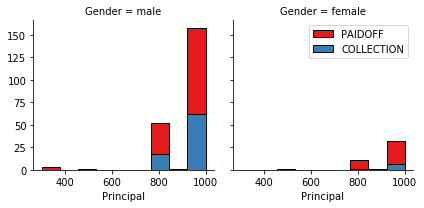

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

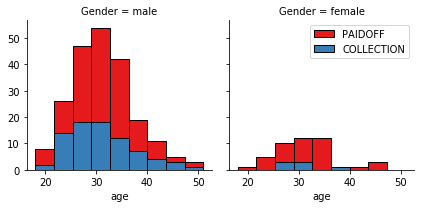

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

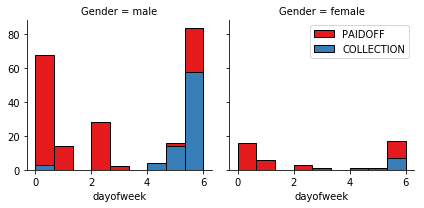

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

#### <font color = 'blue'> Splitting the data into train and test sets </font>

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=4)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (311, 8) (311,)
Test set: (35, 8) (35,)


#### <font color = 'blue'> Creating a baseline K-Nearest Neigbor Classification model with 5 neighbors which is the default number of neighbors in sklearn's implementation </font>

In [21]:
# Create the model
knn_clf =  KNeighborsClassifier() # the number of neighbors is not set as 5 neighbors are used and sklearn's implementation uses 5 neighbors by default.
knn_model = knn_clf.fit(x_train,y_train)

# Show knn summary with the hyperparameters
print('Summary of Baseline', knn_clf)

# Make predictions and print them
train_pred = knn_clf.predict(x_train) # get predicitions on train set
y_pred = knn_clf.predict(x_test) # get predictions on test set (validation set)
#print('\n\n Predictions of Baseline KNN Model on Training Set: \n\n', train_pred)
print('\n\n Predictions of Baseline KNN Model on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Baseline KNN Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline KNN Model on Training Set : ', test_acc * 100, '%')


Summary of Baseline KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')


 Predictions of Baseline KNN Model on Testing Set : 

 ['PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Baseline KNN Model on Training Set :  81.35048231511254 %
Accuracy of Baseline KNN Model on Training Set :  77.14285714285715 %


#### <font color = 'blue'> Creating a KNN models with different number of neighbors. KNN has a problem where everytime it will randomly assign to a sample if there are equal number of samples in all classes. Since our dataset has 2 classes, this problem will occur everytime when there are even number of neighbors set. Hence, to overcome this, only odd number of neighbors will be used in the range of 1 and 50 </font>

K =  17 yields the best accuracy which is  85.71428571428571 %


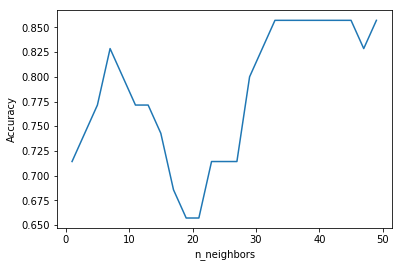



Accuracy of KNN Model with 17 Neigbors on Training Set :  81.35048231511254 %
Accuracy of KNN Model with 17 Neigbors on Training Set :  85.71428571428571 %


In [22]:
# Create a list to store the accuracies of all the knn models
accuracies = []

for n in range(1,50,2) :
    knn_clf =  KNeighborsClassifier(n_neighbors=n)
    knn_model = knn_clf.fit(x_train,y_train)
    y_pred = knn_clf.predict(x_test)
    acc = accuracy_score(y_test,y_pred)
    accuracies.append(acc)
    
accuracies = np.array(accuracies) # np.array can also be used but it will create a copy of the list 'accuracies' which can be intensive for memory. Hence np.asarray is used which doesn't create copies

plt.plot(range(1,50,2), accuracies)
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")

print('K = ', accuracies.argmax()+1, 'yields the best accuracy which is ', accuracies.max() * 100, '%')
plt.show()

train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('\n\nAccuracy of KNN Model with 17 Neigbors on Training Set : ', train_acc * 100, '%')
print('Accuracy of KNN Model with 17 Neigbors on Training Set : ', test_acc * 100, '%')

# Decision Tree

#### <font color = 'blue'> Creating a baseline Decision Tree Classification Model with default hyperparameters used in sklearn's implementation </font>

In [23]:
# Since the data has already been split into train and test sets, hence there is no need to split it again

# Create the baseline model
decision_tree_clf =  DecisionTreeClassifier() # all the default hyperparameters will be used
decision_tree_model = decision_tree_clf.fit(x_train,y_train)

# Show decision tree summary with the hyperparameters
print('Summary of Baseline', decision_tree_clf)

# Make predictions and print them
train_pred = decision_tree_clf.predict(x_train) # get predicitions on train set
y_pred = decision_tree_clf.predict(x_test) # get predictions on test set (validation set)
#print('\n\n Predictions of Baseline Decision Tree Model on Training Set: \n\n', train_pred)
print('\n\n Predictions of Baseline Decision Tree Model on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Baseline Decision Tree Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline Decision Tree Model on Training Set : ', test_acc * 100, '%')



Summary of Baseline DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


 Predictions of Baseline Decision Tree Model on Testing Set : 

 ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Baseline Decision Tree Model on Training Set :  90.03215434083602 %
Accuracy of Baseline Decision Tree Model on Training Set :  68.57142857142857 %


#### <font color = 'blue'> Using GridSearchCV to find the best set of hyperparameters for Decision Tree Classification Model with default hyperparameters used in sklearn's implementation </font>

In [24]:
# Create a list of hyperparameters with different values
params = {'criterion' : ['gini','entropy'],
          'max_features': [i for i in range(1,7)],
          'max_depth' : [8,16,32,64,128,256,512,1024],
          'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
          'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True)}

decision_tree_clf = DecisionTreeClassifier()        
decision_tree_grid = GridSearchCV(decision_tree_clf,param_grid=params) # hyperparameter tuning model
decision_tree_model = decision_tree_grid.fit(x_train,y_train)

print('Parameter sets were : \n',decision_tree_model.param_grid)
print('\n\n\n\n')
print('Best Hyper Parameters :\n',decision_tree_model.best_params_)

train_pred = decision_tree_grid.predict(x_train) # get predicitions on train set
y_pred = decision_tree_grid.predict(x_test) # get predictions on test set (validation set)
print('\n\n Predictions of Decision Tree Model with Best Parameters on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Decision Tree Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of Decision Tree Model with Best Parameters on Training Set : ', test_acc * 100, '%')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Parameter sets were : 
 {'criterion': ['gini', 'entropy'], 'max_features': [1, 2, 3, 4, 5, 6], 'max_depth': [8, 16, 32, 64, 128, 256, 512, 1024], 'min_samples_split': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'min_samples_leaf': array([0.1, 0.2, 0.3, 0.4, 0.5])}





Best Hyper Parameters :
 {'criterion': 'gini', 'max_depth': 1024, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1}


 Predictions of Decision Tree Model with Best Parameters on Testing Set : 

 ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Decision Tree Model with Best Parameters on Training Set :  73.95498392282958 %
Accuracy of Decisi

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


#### <font color = 'blue'> Visualizing Decision Tree Classification Model</font>

# Support Vector Machine

#### <font color = 'blue'> Creating a baseline SVM Classification Model with default hyperparameters used in sklearn's implementation </font>

In [25]:
# Since the data has already been split into train and test sets, hence there is no need to split it again

# Create the baseline model
svm_clf =  SVC() # all the default hyperparameters will be used
svm_model = svm_clf.fit(x_train,y_train)

# Show decision tree summary with the hyperparameters
print('Summary of Baseline', svm_clf)

# Make predictions and print them
train_pred = svm_clf.predict(x_train) # get predicitions on train set
y_pred = svm_clf.predict(x_test) # get predictions on test set (validation set)
#print('\n\n Predictions of Baseline KNN Model on Training Set: \n\n', train_pred)
print('\n\n Predictions of Baseline SVM Model on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Baseline SVM Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline SVM Model on Training Set : ', test_acc * 100, '%')

Summary of Baseline SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


 Predictions of Baseline SVM Model on Testing Set : 

 ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF'
 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Baseline SVM Model on Training Set :  77.81350482315112 %
Accuracy of Baseline SVM Model on Training Set :  77.14285714285715 %


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### <font color = 'blue'> Using GridSearchCV to find the best set of hyperparameters for SVM Classification Model with default hyperparameters used in sklearn's implementation </font>

In [26]:
# Create a list of hyperparameters with different values
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'gamma' : [0.001, 0.01, 0.1, 1],
          'kernel': ['linear','rbf']}

svm_clf = SVC()        
svm_grid = GridSearchCV(svm_clf,param_grid=params) # hyperparameter tuning model
svm_model = svm_grid.fit(x_train,y_train)

print('Parameter sets were : \n',svm_model.param_grid)
print('\n')
print('Best Hyper Parameters :\n',svm_model.best_params_)

train_pred = svm_grid.predict(x_train) # get predicitions on train set
y_pred = svm_grid.predict(x_test) # get predictions on test set (validation set)
print('\n\n Predictions of SVM Model with Best Parameters on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of SVM Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of SVM Model with Best Parameters on Training Set : ', test_acc * 100, '%')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Parameter sets were : 
 {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}


Best Hyper Parameters :
 {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


 Predictions of SVM Model with Best Parameters on Testing Set : 

 ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF'] 


Accuracy of SVM Model with Best Parameters on Training Set :  84.88745980707395 %
Accuracy of SVM Model with Best Parameters on Training Set :  80.0 %


# Logistic Regression

#### <font color = 'blue'> Creating a baseline Logistic Regression Model with default hyperparameters used in sklearn's implementation </font>

In [27]:
# Since the data has already been split into train and test sets, hence there is no need to split it again

# Create the baseline model
log_reg_clf =  LogisticRegression() # all the default hyperparameters will be used
log_reg_model = log_reg_clf.fit(x_train,y_train)

# Show decision tree summary with the hyperparameters
print('Summary of Baseline', log_reg_clf)

# Make predictions and print them
train_pred = log_reg_clf.predict(x_train) # get predicitions on train set
y_pred = log_reg_clf.predict(x_test) # get predictions on test set (validation set)
#print('\n\n Predictions of Baseline KNN Model on Training Set: \n\n', train_pred)
print('\n\n Predictions of Baseline Logistic Regression Model on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Baseline Logistic Regression Model on Training Set : ', train_acc * 100, '%')
print('Accuracy of Baseline Logistic Regression Model on Validation Set : ', test_acc * 100, '%')

Summary of Baseline LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


 Predictions of Baseline Logistic Regression Model on Testing Set : 

 ['COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Baseline Logistic Regression Model on Training Set :  74.27652733118971 %
Accuracy of Baseline Logistic Regression Model on Validation Set :  80.0 %


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### <font color = 'blue'> Using GridSearchCV to find the best set of hyperparameters for Logistic Regression Model with default hyperparameters used in sklearn's implementation </font>

In [28]:
# Create a list of hyperparameters with different values
params = {'C': [0.001,0.01,0.1,1,10,100],
          'penalty' : ['l1','l2']}

log_reg_clf = LogisticRegression()        
log_reg_grid = GridSearchCV(log_reg_clf,param_grid=params) # hyperparameter tuning model
log_reg_model = log_reg_grid.fit(x_train,y_train)

print('Parameter sets were : \n',log_reg_model.param_grid)
print('\n')
print('Best Hyper Parameters :\n',log_reg_model.best_params_)

train_pred = log_reg_grid.predict(x_train) # get predicitions on train set
y_pred = log_reg_grid.predict(x_test) # get predictions on test set (validation set)
print('\n\n Predictions of Logistic Regression Model with Best Parameters on Testing Set : \n\n', y_pred, '\n\n')

# Calculate accuracies on training and testing sets
train_acc = accuracy_score(y_train,train_pred)
test_acc = accuracy_score(y_test,y_pred)

print('Accuracy of Logistic Regression Model with Best Parameters on Training Set : ', train_acc * 100, '%')
print('Accuracy of Logistic Regression Model with Best Parameters on Training Set : ', test_acc * 100, '%')

Parameter sets were : 
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}


Best Hyper Parameters :
 {'C': 0.1, 'penalty': 'l1'}


 Predictions of Logistic Regression Model with Best Parameters on Testing Set : 

 ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'] 


Accuracy of Logistic Regression Model with Best Parameters on Training Set :  73.95498392282958 %
Accuracy of Logistic Regression Model with Best Parameters on Training Set :  85.71428571428571 %


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/line

# Model Evaluation using Test set

In [29]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [30]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2019-12-28 22:34:25--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2019-12-28 22:34:25 (311 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing the Test Set

In [32]:
# Convert the effective_date and due_date columns to a datetime object
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['due_date'] = pd.to_datetime(test_df['due_date'])

# Drop the Unnamed: 0 and Unnamed: 1 columns using indexing
test_df = test_df.drop(test_df.columns[test_df.columns.str.contains('unnamed',case = False)],axis = 1)
test_df.head()

# One Hot Code the Gender column
test_df['Gender'][test_df['Gender'] == 'male'] = 1
test_df['Gender'][test_df['Gender'] == 'female'] = 0

# Create a "dayofweek" column in test_df
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend']=test_df['dayofweek'].apply(lambda x:1 if(x>3) else 0)

Feature_test = test_df[['Principal','terms','age','Gender','weekend']]
Feature_test = pd.concat([Feature_test,pd.get_dummies(test_df['education'])], axis=1)
Feature_test.drop(['Master or Above'], axis = 1,inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
test_x = Feature_test
test_target=pd.get_dummies(test_df['loan_status'])
test_target.drop(['COLLECTION'], axis =1, inplace= True)

test_y=test_target

test_x = preprocessing.StandardScaler().fit(test_x).transform(test_x)
test_x[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: DataConversionWarning: Data with input dtype uint8, int64, object were all converted to float64 by StandardScaler.


array([[ 0.49362588,  0.92844966,  3.05981865, -1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596, -1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942,  0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

### Evaluation on Test Set

In [34]:
knn_test_pred = knn_clf.predict(test_x)
knn_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in knn_test_pred]
knn_jaccard = jaccard_similarity_score(test_y, knn_test_pred)
knn_jaccard

0.7962962962962963

In [35]:
# Evaluate on KNN Classifier
knn_test_pred = knn_clf.predict(test_x)
knn_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in knn_test_pred] # One Hot Code knn_test_pred to get integers for jaccard similarity score and f1 score
knn_jaccard = jaccard_similarity_score(test_y, knn_test_pred)
knn_f1 = f1_score(test_y, knn_test_pred)

# Evaluate on Decision Tree Classifier
decision_tree_pred = decision_tree_grid.predict(test_x)
decision_tree_pred = [1 if x == 'PAIDOFF'  else 0 for x in decision_tree_pred] # One Hot Code decision_tree_pred to get integers for jaccard similarity score and f1 score
decision_tree_jaccard = jaccard_similarity_score(test_y, decision_tree_pred)
decision_tree_f1 = f1_score(test_y, decision_tree_pred)

# Evaluate on SVM Classifier
svm_test_pred = svm_grid.predict(test_x)
svm_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in svm_test_pred] # One Hot Code svm_test_pred to get integers for jaccard similarity score and f1 score
svm_jaccard = jaccard_similarity_score(test_y, svm_test_pred)
svm_f1 = f1_score(test_y, svm_test_pred)
svm_logloss = log_loss(test_y, svm_test_pred)

# Evaluate on Logisitic Regression
log_reg_test_pred = log_reg_grid.predict(test_x)
log_reg_test_pred = [1 if x == 'PAIDOFF'  else 0 for x in log_reg_test_pred] # One Hot Code log_reg_test_pred to get integers for jaccard similarity score and f1 score
log_reg_jaccard = jaccard_similarity_score(test_y, log_reg_test_pred)
log_reg_f1 = f1_score(test_y, log_reg_test_pred)
log_reg_logloss = log_loss(test_y, log_reg_test_pred)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [36]:
col_names =  ['Algorithm','Jaccard Similarity Score', 'F1 Score','Log Loss']
Report_df = pd.DataFrame(columns = col_names)
Report_df.loc[len(Report_df)] = ['KNN', knn_jaccard,knn_f1, 'NA']
Report_df.loc[len(Report_df)] = ['Decision Tree', decision_tree_jaccard,decision_tree_f1, 'NA']
Report_df.loc[len(Report_df)] = ['SVM', svm_jaccard,svm_f1, svm_logloss]
Report_df.loc[len(Report_df)] = ['Logistic Regression', log_reg_jaccard,log_reg_f1, log_reg_logloss]
Report_df.style.hide_index()

Algorithm,Jaccard Similarity Score,F1 Score,Log Loss
KNN,0.796296,0.879121,NA
Decision Tree,0.777778,0.846154,NA
SVM,0.703704,0.826087,10.2339
Logistic Regression,0.740741,0.851064,8.9547


### <font color = 'Red'> In case of the accuracies for training and validation sets, Decision Tree Classifier performed the best with default parameters (90% accuracy) on the training set while KNN performed the best with parameter tuning, with K = 17 (86% accuracy) on the validation set </font>

### <font color = 'Red'> In case of the jaccard similarity score and f1 score on <b> UNSEEN DATA </b>, KNN performed the best with jaccard similarity score of 0.796296 and f1 score of 0.879121 </font>

### <font color = 'Red'> In terms of overall performance, KNN Classifier is the Best Classifier amongest all the Classifiers </font>

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>